In [2]:
import json
import importlib
import os
import sys
import xml
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.utils import parse_lipid, parse_p_value, tight_bbox
from src import plots
import src.Fig4_subplots
importlib.reload(plots)

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'

plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
import networkx as nx
from scipy.cluster.hierarchy import linkage
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
# import pylustrator

In [3]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

In [4]:
id_lipids_idx = data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'Unidentified')].index

data.loc[id_lipids_idx, 'fa_unsat'] = data.loc[id_lipids_idx, 'ID'].apply(lambda x: parse_lipid(x)[3])
data.loc[id_lipids_idx, 'fa_len'] = data.loc[id_lipids_idx, 'ID'].apply(lambda x: parse_lipid(x)[2])

In [5]:
ldf = data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'Unidentified'), rbg_cols]
lipids_idx = ldf.index
tgs_idx = data.loc[data['molec_class'] == 'TG'].index

results = {}
for col_name, cols in [('rbg', rbg_cols), ('fbg', fbg_cols), ('all', data_cols)]:
    results[col_name] = {}
    for idx_name, idx in [('TG', tgs_idx), ('lipids', lipids_idx)]:
        df = data.loc[idx, cols]
        df = StandardScaler().fit_transform(df)
        pca_obj = PCA(n_components=5).fit(df)
        result = pd.DataFrame(pca_obj.transform(df), 
                              columns=[f'd{x+1}' for x in range(pca_obj.n_components)], 
                              index=idx)
        results[col_name][idx_name] = {'r': result, 'pca_obj': pca_obj}



atg_obj = results['all']['TG']['pca_obj']
rli_obj = results['rbg']['lipids']['pca_obj']
rpca = results['rbg']['TG']['r']
rpca = rpca.join(data[['fa_unsat']])
rpca

d1        d2        d3        d4        d5  fa_unsat
i                                                                 
l_569 -11.377147  2.012965  0.410747  0.120104 -0.185133      17.0
l_582 -11.609341  2.180144 -0.502490 -0.171284 -0.485599      18.0
l_590  -5.258500  0.913159  1.513127  0.231096  0.390863      12.0
l_603   0.026191  1.576023  0.446953  0.113550 -0.000637      13.0
l_611  -2.765372  1.578352  0.349459  0.041436 -0.106859      14.0
...          ...       ...       ...       ...       ...       ...
l_905  -8.561714 -1.106989  0.206553  0.104563 -0.553436       2.0
l_907  -4.826552 -0.620765  0.141154  0.236457 -0.320163       1.0
l_908  -6.921085 -0.702277 -0.017962  0.084775 -0.134987       3.0
l_910  -6.779527 -0.441041 -0.993287 -0.060080 -0.434318       2.0
l_912  -5.513006 -0.437739  0.730546  0.391110 -0.365691       0.0

[107 rows x 6 columns]

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif


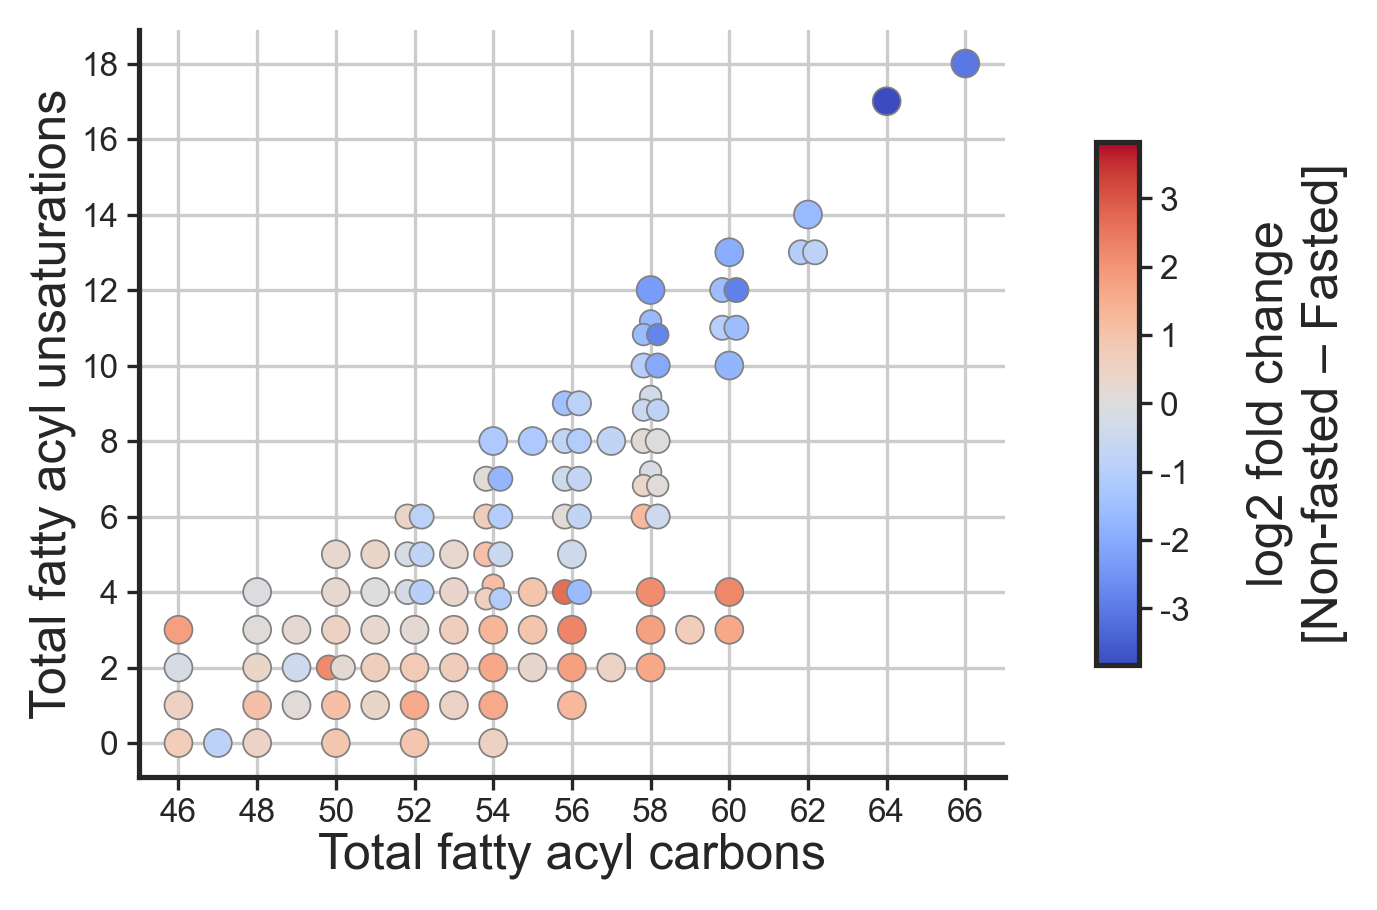

In [36]:
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['axes.labelsize'] = 12
fig, (ax, cax) = plt.subplots(ncols=2, dpi=300, figsize=(4.3, 3.3),
                              gridspec_kw=dict(width_ratios=[1, 0.05]))
axc, cbar = src.Fig4_subplots.make_carbon_unsat_plot(
    'TG', 0.18, ax=ax, cax=cax, base_size=45
)
ax.tick_params( length=3, pad=2, labelsize=8)
cax.tick_params(length=3, pad=2, labelsize=8)
plt.savefig('../reports/figures/Figure5/TG_unsat_carbon_plot.pdf', 
            dpi=300, bbox_inches='tight')

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans

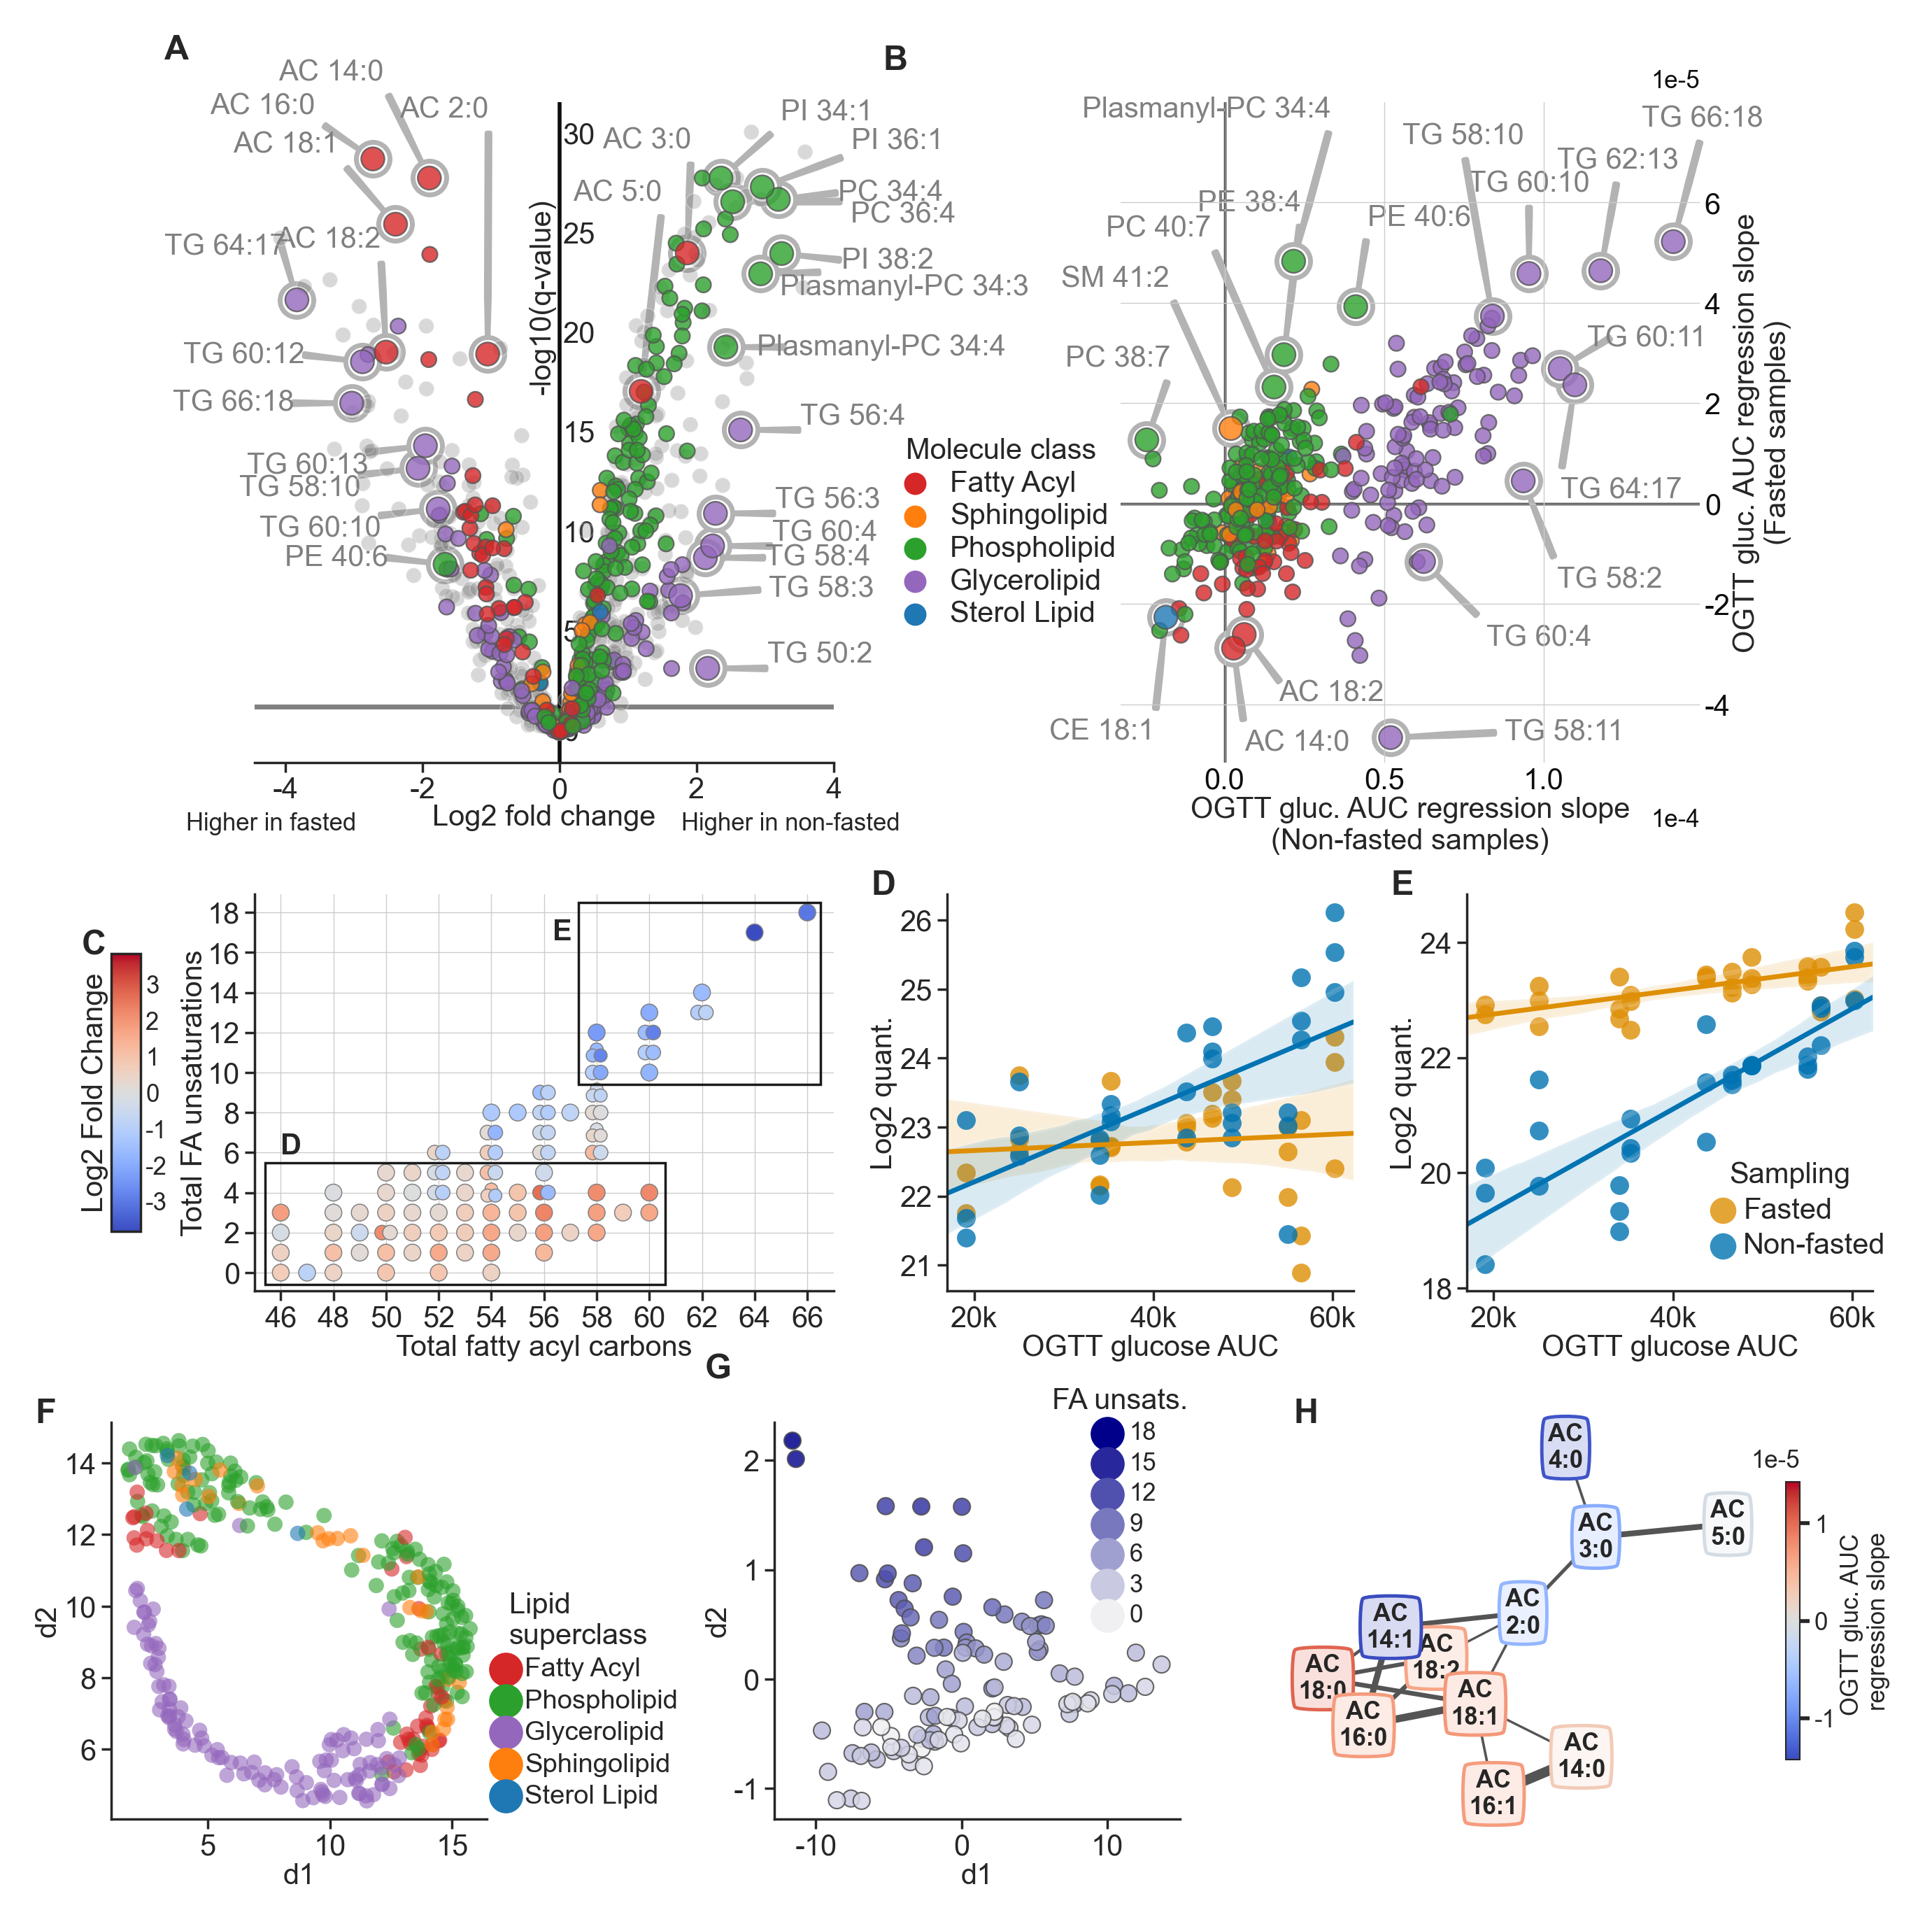

In [85]:
# plt.rcParams['xtick.major.pad'] = 1
# plt.rcParams['xtick.major.size'] = 0.0
# plt.rcParams['xtick.major.width'] = 1
plt.rcParams['axes.labelpad'] = 0.5
# plt.rcParams['axes.spines.right'] = 0
# plt.rcParams['axes.spines.top'] = 0
# plt.rcParams['lines.markersize'] = 5
importlib.reload(src.Fig4_subplots)
importlib.reload(src.plots)
fig, axs = plt.subplot_mosaic(
    """
    .AAAA.BBBB.
    .AAAA.BBBB.
    .AAAA.BBBB.
    cCCCCDDDEEE
    cCCCCDDDEEE
    FFF.GGGHHHH
    FFF.GGGHHHH
    """,
    gridspec_kw=dict(hspace=1, wspace=2, 
                     width_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    ),
    figsize=(6.5, 6.5), dpi=500, facecolor='white',
)
# SET SPINE WIDTHS FOR ALL AXES
for ax in axs.values():
    ax.tick_params(length=2, pad=1, labelsize=6, width=0.5)
    for side in ['top','bottom','left','right']:
        ax.spines[side].set_linewidth(0.5)

src.Fig4_subplots.lipid_volcano_plot(ax=axs['A'])
axs['A'].set_xlabel('Log2 fold change', fontsize=6, labelpad=0)
axs['A'].set_xticks([-4, -2, 0, 2, 4])

src.Fig4_subplots.lipid_coef_coef_plot(ax=axs['B'])
axs['B'].set_ylim(top=axs['B'].get_ylim()[1] * 1.4)
# axs['B'].set_xticks([-5e-5, 0, 5e-5, 10e-5, 15e-5])

axc, cbar = src.Fig4_subplots.make_carbon_unsat_plot(
    lipid_class='TG', jitter_o0.15, ax=axs['C'], cax=axs['c'], base_size=12)
# axc.tick_params(pad=1, length=2, labelsize=5)
axc.grid(linewidth=0.2)
axc.set_ylabel('Total FA unsaturations', fontsize=6, labelpad=0)
cbar.ax.tick_params(pad=1, length=0, labelsize=5)
cbar.ax.set_ylabel('Log2 Fold Change')
cbar.ax.yaxis.set_label_position('left')
cbar.outline.set_linewidth(0.5)

tg05 = data.loc[(data['molec_class'] == 'TG') & (data['fa_unsat'] < 6)].index
tg10 = data.loc[(data['molec_class'] == 'TG') & (data['fa_unsat'] > 9)].index
src.plots.plot_quant_vs_ogtt(feature=tg05, ax=axs['D'], scatter_kws=dict(s=15, lw=0), line_kws=dict(lw=1))
src.plots.plot_quant_vs_ogtt(feature=tg10, ax=axs['E'], scatter_kws=dict(s=15, lw=0), line_kws=dict(lw=1), 
                             legend=True)
axs['D'].set(ylabel='Log2 quant.', xlabel='OGTT glucose AUC')
axs['E'].set(ylabel='Log2 quant.', xlabel='OGTT glucose AUC')
axs['E'].legend(loc=(0.53, 0.05), handletextpad=-0.3, markerscale=1.4, labelspacing=0.3, title='Sampling', 
                title_fontsize=6, fontsize=6)
axs['C'].add_patch(plt.Rectangle((45.4, -0.6), 15.2, 6.1, facecolor='none', edgecolor='0.1', linewidth=0.5))
axs['C'].add_patch(plt.Rectangle((57.3, 9.4), 9.2, 9.1, facecolor='none', edgecolor='0.1', linewidth=0.5))
axs['C'].text(46.4, 6.3, 'D', fontweight='bold', fontsize=6, va='center', ha='center')
axs['C'].text(56.7, 17, 'E', fontweight='bold', fontsize=6, va='center', ha='center')

sns.scatterplot(
    data=l, x='d1', y='d2', hue='superclass', ax=axs['F'], s=10,
    alpha=0.6, edgecolor='0.3', linewidth=0, palette=colors,)
sns.scatterplot(
    data=rpca, x='d1', y='d2', hue='fa_unsat', ax=axs['G'],
    palette=sns.light_palette('darkblue', as_cmap=True), 
    alpha=0.85, edgecolor='0.3', linewidth=0.3, s=12)
# sns.scatterplot(
#     data=rpca, x='d1', y='d2', hue='fa_len', ax=axs['H'], 
#     palette=sns.light_palette('black', as_cmap=True), 
#     alpha=0.6, edgecolor='0.3', linewidth=0.3, s=12)

axs['F'].legend(loc=(0.95, 0), handletextpad=-0.3, markerscale=1, labelspacing=0.3, title='Lipid\nsuperclass', 
           title_fontsize=6, fontsize=5.5)
lhandles, llabels = axs['G'].get_legend_handles_labels()
axs['G'].legend(handles=lhandles[::-1], labels=llabels[::-1],
    loc=(0.66, 0.46), handletextpad=-0.1, markerscale=1, labelspacing=0.3, title='FA unsats.', 
           title_fontsize=6, fontsize=5)
# axs['H'].legend(loc=(0.7, 0.45), handletextpad=-0.3, markerscale=1, labelspacing=0.3, title='FA carbons', 
#            title_fontsize=6, fontsize=5.5)

src.plots.plot_graph(metab_set=data.loc[data['molec_class'].isin(['AC'])].index, ax=axs['H'],
                     corr=0.365, corr_type='pearson')
axs['H'].margins(0.02)

for ax in [axs['F'], axs['G']]:
    ax.tick_params(labelsize=6, pad=1, length=2, width=0.5)
    sns.despine(ax=ax)
for ax_letter in ['A', 'B', 'c', 'D', 'E', 'F', 'G', 'H']:
    ax = axs[ax_letter]
    bb = tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1, s=ax_letter.upper(), transform=fig.transFigure, fontweight='bold', fontsize=7)
    
# plt.savefig('../reports/figures/Figure5/fig5.png', facecolor='white', dpi=500, bbox_inches='tight')
# plt.savefig('../reports/figures/Figure5/fig5.pdf', facecolor='white', dpi=500, bbox_inches='tight')


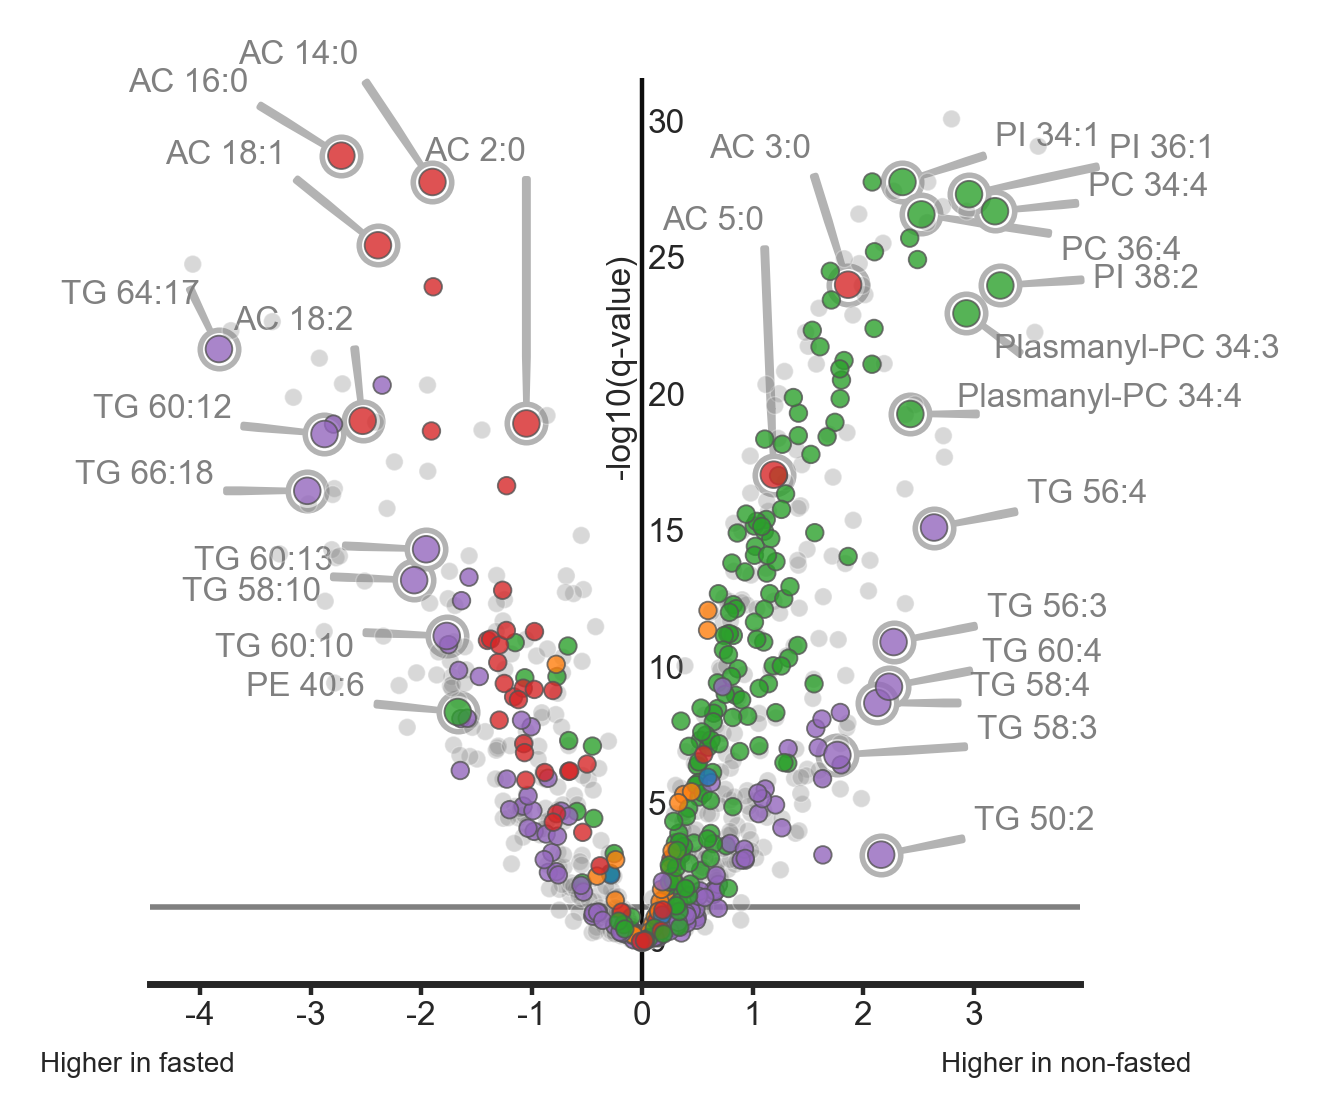

In [72]:
importlib.reload(src.Fig4_subplots)
fig, ax = plt.subplots(figsize=(3, 3), dpi=400)
src.Fig4_subplots.lipid_volcano_plot(ax=ax)

In [35]:
df = data.loc[(data['superclass'] != 'Unidentified') & (data['Type'] == 'lipid')].copy()
df['i'] = df.index
px.scatter(
    df, x='Log2 Fold Change', y='log_qval_sampling', color='superclass', # color_discrete_map=colors,
#     color_discrete_map=colors,
    hover_data=['ID', 'i', 'molec_class'], 
)

In [25]:
df = data.loc[(data['superclass'] != 'Unidentified') & (data['Type'] == 'lipid')].copy()
df['i'] = df.index
px.scatter(
    df, x='coef_fed', y='coef_fasted', color='superclass', 
#     color_discrete_map=colors,
    hover_data=['ID', 'i', 'molec_class'], 
)

In [ ]:
outliers = {  # lcc = lipid coef-coef 
    'l_582': dict(x=0.99, y=0.99, name='TG 22:6_22:6_22:6'),
    'l_623': dict(x=0.9, y=0.15, name='TG 62:13'),
    'l_716': dict(x=-0.15, y=0.1, name='TG 60:10'),
    'l_569': dict(x=0.05, y=-0.2, name='TG 20:5_22:6_22:6'),
    'l_910': dict(x=0.05, y=-0.2, name='TG 58:2'),
    'l_644': dict(x=-0.05, y=0.05, name='TG 18:2_18:2_22:6'),
    'l_372': dict(x=-0.05, y=0.05, name='PE 18:0_22:6'),
    'l_241': dict(x=-0.15, y=0.05, name='Plasmanyl-PC O-34:4'),
    'l_404': dict(x=-0.2, y=0.1, name='PE 18:0_20:4'),
    'l_888': dict(x=0.2, y=-0.2, name='TG 18:2_18:1_24:1'),
    'l_617': dict(x=0.3, y=0.0, name='TG 18:1_20:5_20:5'),
    'l_10': dict(x=0.02, y=-0.1, name='AC 14:0'),
    'l_4': dict(x=0.05, y=-0.1, name='AC 18:2'),
    'l_1': dict(x=0.0, y=-0.15, name='AC 4:0'),
    'l_32': dict(x=-0.05, y=-0.05, name='LysoPC 17:1'),
    'l_844': dict(x=-0.05, y=0.0, name='CE 18:1'),
    'l_47': dict(x=-0.05, y=0.02, name='LysoPC 18:1'),
    'l_197': dict(x=-0.05, y=0.0, name='PC 38:7'),
    'l_507': dict(x=-0.2, y=0.2, name='SM d41:2'),
    'l_232': dict(x=-0.2, y=0.2, name='PC O-40:7'),
}

Text(56.7, 17, 'E')

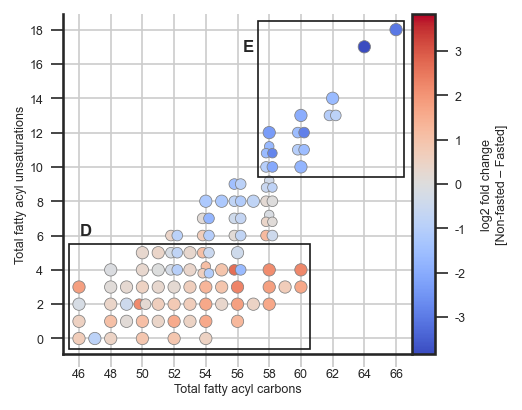

In [602]:
importlib.reload(src.Fig4_subplots)
importlib.reload(src.utils)

ax, cbar = src.Fig4_subplots.make_carbon_unsat_plot('TG', 0.2, base_size=35)
plt.gcf().set_size_inches(6, 3)

ax.add_patch(plt.Rectangle((45.4, -0.6), 15.2, 6.1, facecolor='none', edgecolor='0.1', linewidth=0.8))
ax.add_patch(plt.Rectangle((57.3, 9.4), 9.2, 9.1, facecolor='none', edgecolor='0.1', linewidth=0.8))
ax.text(46.4, 6.3, 'D', fontweight='bold', fontsize=8, va='center', ha='center')
ax.text(56.7, 17, 'E', fontweight='bold', fontsize=8, va='center', ha='center')

In [682]:
axs['B'].transLimits.transform((1e-4, 4e-5))

array([0.7304824 , 0.69588808])

# What happens if you cluster lipid features using UMAP/PCA?

In [399]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [20]:
lu = UMAP(n_neighbors=15, n_components=5, metric='cosine', min_dist=0.9, random_state=43)\
        .fit_transform(StandardScaler().fit_transform(ldf)) 
l = pd.DataFrame(lu, columns=[f'd{x+1}' for x in range(lu.shape[1])], index=lipids_idx)\
      .join(data[['fa_unsat', 'fa_len', 'molec_class', 'superclass']])

# umap = UMAP(n_neighbors=15, n_components=5, metric='euclidean', random_state=43,)
umap = UMAP(n_neighbors=15, n_components=5, metric='euclidean', random_state=43,)

# au = umap.fit_transform(StandardScaler().fit_transform(adf))
# ru = umap.fit_transform(StandardScaler().fit_transform(rdf))
# fu = umap.fit_transform(StandardScaler().fit_transform(fdf))
                    
# a = pd.DataFrame(au, columns=[f'd{x+1}' for x in range(au.shape[1])], index=tgs_idx).join(data[['fa_unsat', 'fa_len']])
# r = pd.DataFrame(ru, columns=[f'd{x+1}' for x in range(ru.shape[1])], index=tgs_idx).join(data[['fa_unsat', 'fa_len']])
# f = pd.DataFrame(fu, columns=[f'd{x+1}' for x in range(fu.shape[1])], index=tgs_idx).join(data[['fa_unsat', 'fa_len']])

ValueError: Could not interpret value `fa_len` for parameter `hue`

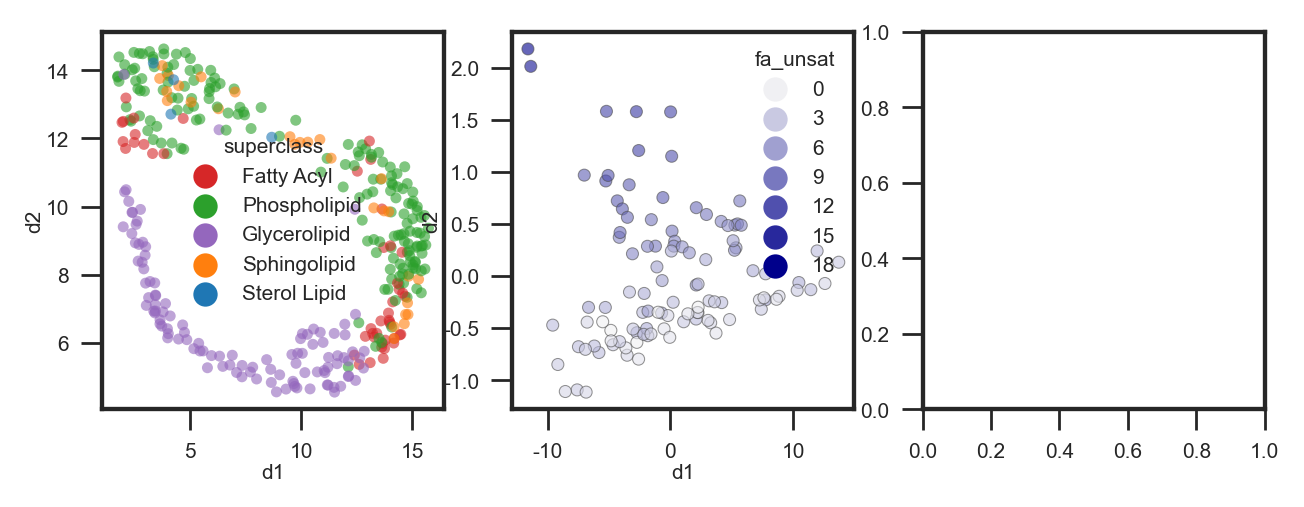

In [21]:
fig, [ax0, ax1, ax2] = plt.subplots(ncols=3, figsize=(6, 2), dpi=250)

sns.scatterplot(
    data=l, x='d1', y='d2', hue='superclass', ax=ax0, s=10,
    alpha=0.6, edgecolor='0.3', linewidth=0, 
    palette=colors,
)
df = rpca
sns.scatterplot(
    data=rpca, x='d1', y='d2', hue='fa_unsat', ax=ax1,
    palette=sns.light_palette('darkblue', as_cmap=True), 
    alpha=0.6, edgecolor='0.3', linewidth=0.3, s=12)
sns.scatterplot(
    data=rpca, x='d1', y='d2', hue='fa_len', ax=ax2, 
    palette=sns.light_palette('black', as_cmap=True), 
    alpha=0.6, edgecolor='0.3', linewidth=0.3, s=12)

ax0.legend(loc=(-0.6, 0), handletextpad=-0.3, markerscale=1, labelspacing=0.3, title='Lipid\nsuperclass', 
           title_fontsize=6, fontsize=6)
ax1.legend(loc=(0.7, 0.5), handletextpad=-0.3, markerscale=1, labelspacing=0.3, title='FA unsats.', 
           title_fontsize=6, fontsize=6)
ax2.legend(loc=(0.7, 0.5), handletextpad=-0.3, markerscale=1, labelspacing=0.3, title='FA carbons', 
           title_fontsize=6, fontsize=6)
for ax in [ax0, ax1, ax2]:
    ax.tick_params(labelsize=6, pad=1, length=2, width=0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

sns.despine()

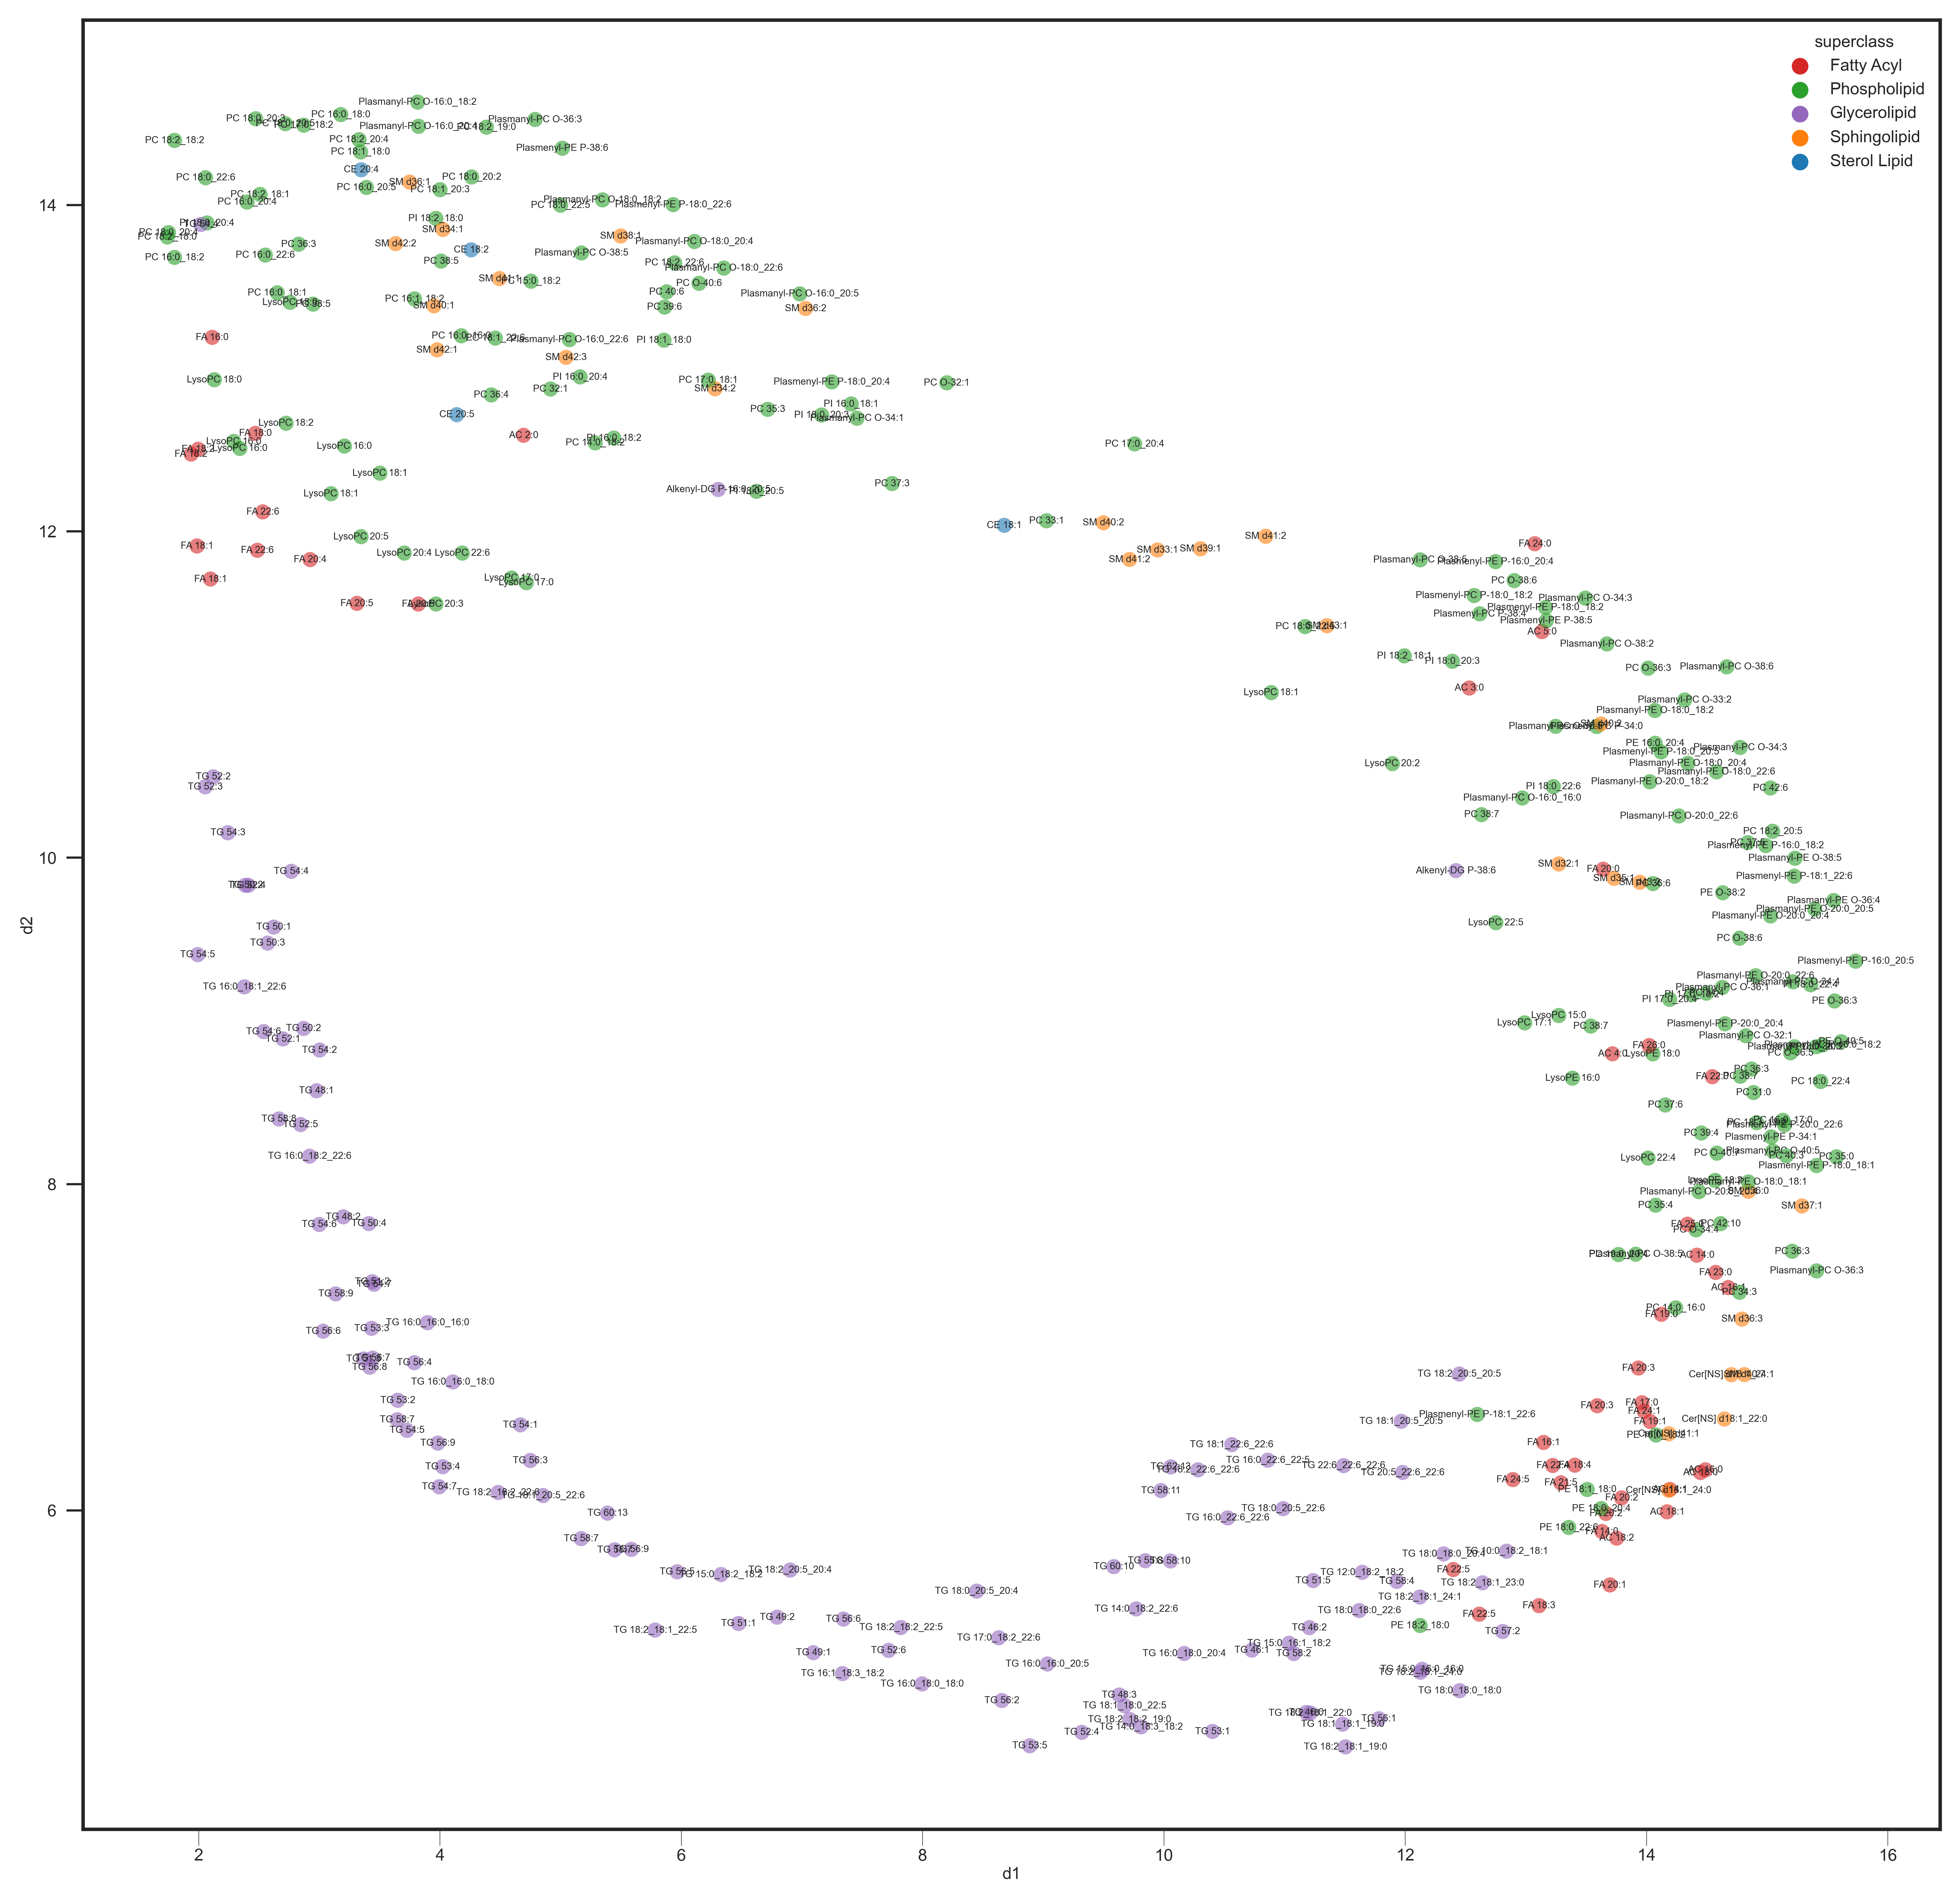

In [512]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=650)
sns.scatterplot(
    data=l, x='d1', y='d2', hue='superclass', ax=ax, s=30,
    alpha=0.6, edgecolor='0.3', linewidth=0, 
    palette=colors,
)
if 'ID' not in l:
    l = l.join(data['ID'])

for i, row in l.iterrows():
    ax.text(row['d1'], row['d2'], row['ID'], fontsize=3.5, ha='center', va='center')

<AxesSubplot:>

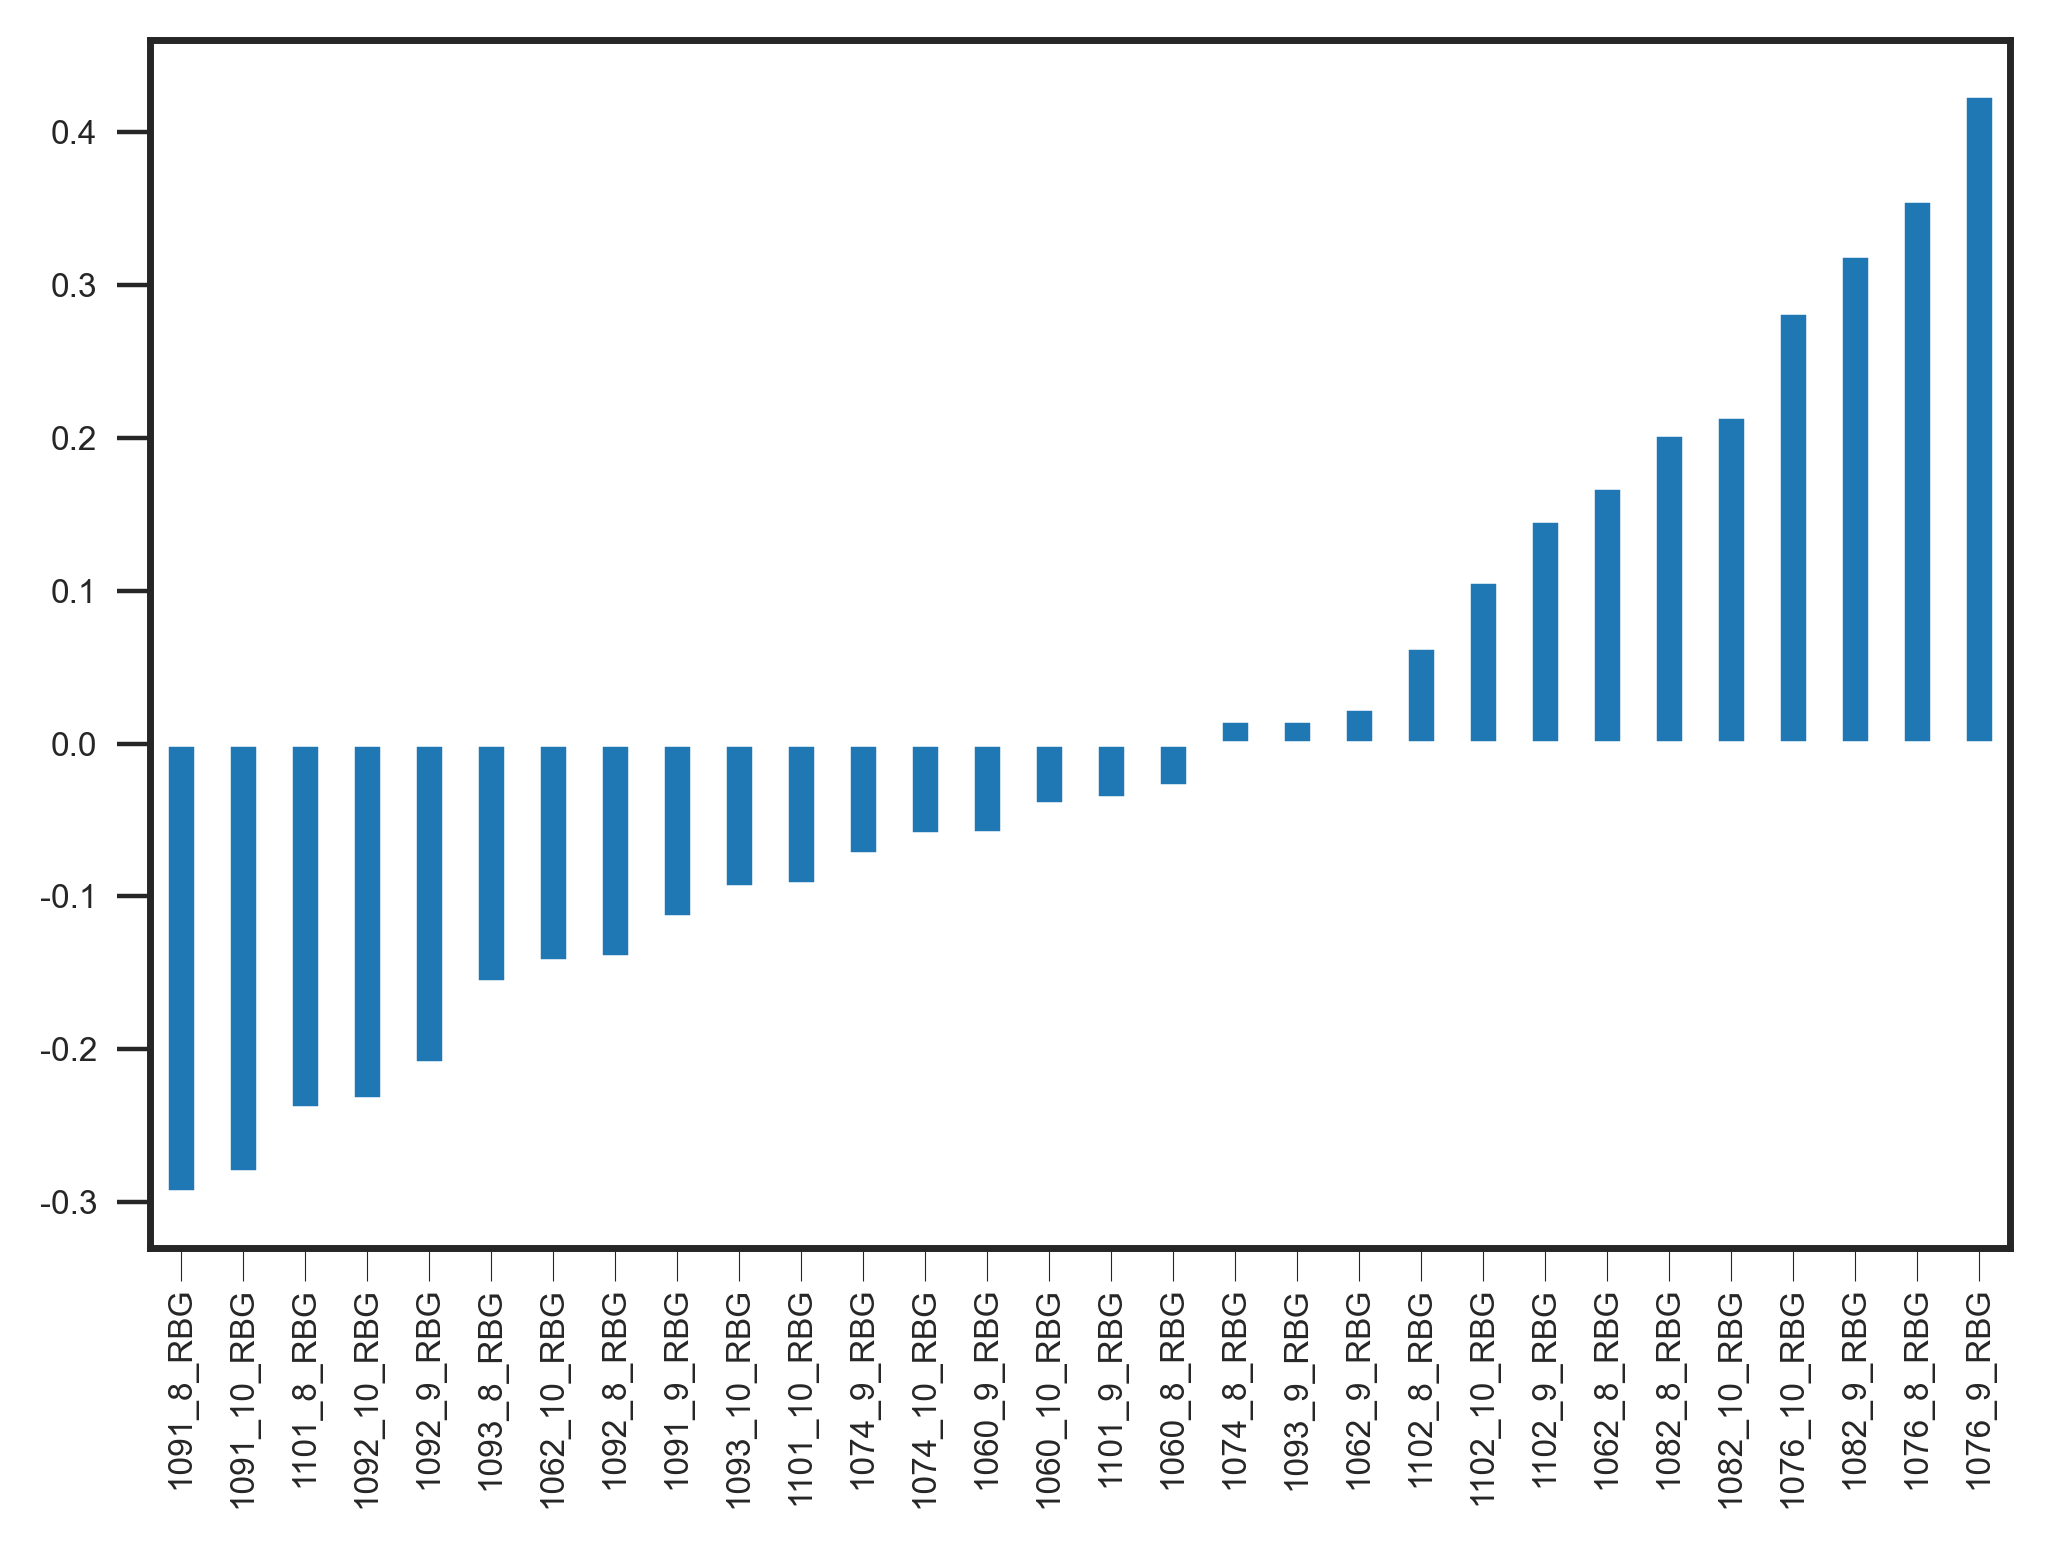

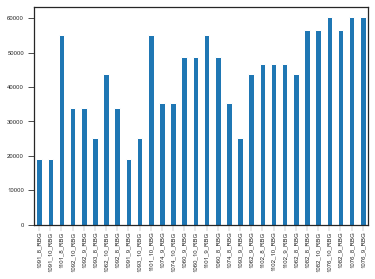

In [671]:
loadings = rli_obj.components_.T * np.sqrt(rli_obj.explained_variance_)

df = pd.DataFrame(loadings, index=rbg_cols)
df = df.join(fg['ogtt'])
df = df.sort_values(1)

df[1].plot.bar()
# df['ogtt'].plot.bar()
plt.gcf().set_dpi(400)
plt.figure()
df['ogtt'].plot.bar()